# DEG helper function

In [2]:
import deg

# read graph from drive
graph_file = "G:/My Drive/HTW/PhD/2DGraph/automatic/L2_K4_AddK10Eps0.2High_SwapK10-0StepEps0.001LowPath5Rnd100+0_improveNonRNGAndSecondHalfOfNonPerfectEdges_RNGAddMinimalSwapAtStep0.add_rng_opt.deg"

graph_file = "G:/My Drive/HTW/PhD/2DGraph/V30_L2_K4_AddK8Eps0.2High_SwapK8-0StepEps0.001Low.deg"

# use features as coords
coords = deg.get_deg_coords(graph_file)
print(coords.shape)
print(coords[:3])

(30, 2)
[[73.01615  25.27309 ]
 [76.6436   81.619644]
 [59.095734 99.37522 ]]


In [1]:
import deglib
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point

def _get_coords(g, index):
    return np.array(g.get_feature_vector(index), dtype=np.float32)

def get_deg_coords(g):
    return np.array([_get_coords(g,i) for i in range(g.size())], dtype=np.float32)

def get_deg_edges(g):
    edges = []
    for i in range(g.size()):
        src_coords = _get_coords(g,i)
        for j in g.get_neighbor_indices(i):
            if i < j:
                dst_coords = _get_coords(g,j)
                line = LineString([src_coords, dst_coords])
                dist = line.length
                edges.append((i, j, line, dist))
    return gpd.GeoDataFrame(edges, columns=["source", "target", "geometry", "weight"])

# Read coords from existing DEG

In [2]:
# read graph from drive
graph_file = "G:/My Drive/HTW/PhD/2DGraph/automatic/L2_K4_AddK10Eps0.2High_SwapK10-0StepEps0.001LowPath5Rnd100+0_improveNonRNGAndSecondHalfOfNonPerfectEdges_RNGAddMinimalSwapAtStep0.add_rng_opt.deg"

graph_file = "G:/My Drive/HTW/PhD/2DGraph/V30_L2_K4_AddK8Eps0.2High_SwapK8-0StepEps0.001Low.deg"

# use features as coords
coords = get_deg_coords(deglib.graph.load_readonly_graph(graph_file))
print(coords.shape)
print(coords[:3])

(30, 2)
[[73.01615  25.27309 ]
 [76.6436   81.619644]
 [59.095734 99.37522 ]]


# Create random coords

In [3]:
def create_random_coords(n=100, scale=100.0, seed=None):
    """
    Create n random 2D coordinates in range [0, scale) as float32.
    """
    if seed is not None:
        np.random.seed(seed)
    return (np.random.rand(n, 2) * scale).astype(np.float32)

# example
#coords = create_random_coords(20, scale=50, seed=42)
print(coords[:5])

[[73.01615  25.27309 ]
 [76.6436   81.619644]
 [59.095734 99.37522 ]
 [92.944084 14.437962]
 [38.930744 35.24164 ]]


# Create the base graphs

In [4]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString

def _pairwise_dist(coords):
    return np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)

def _rng_edges(coords, dist):
    n = len(coords)
    edges = set()
    for i in range(n):
        for j in range(i+1, n):
            dij = dist[i, j]
            keep = True
            for k in range(n):
                if k == i or k == j:
                    continue
                if dist[i, k] < dij and dist[j, k] < dij:
                    keep = False
                    break
            if keep:
                edges.add((i, j))
    return edges

def _to_adj(n, edges):
    adj = [set() for _ in range(n)]
    for i, j in edges:
        adj[i].add(j)
        adj[j].add(i)
    return adj

def _add_edge(i, j, edges, adj):
    a, b = (i, j) if i < j else (j, i)
    if (a, b) not in edges:
        edges.add((a, b))
        adj[i].add(j)
        adj[j].add(i)

def create_mrng(coords):
    """
    Full monotonic enforcement:
    1) start from RNG
    2) for each ordered pair (u, v), enforce a path u->...->v where d(next,v) < d(curr,v)
       by adding repair edges when greedy descent gets stuck
    Returns GeoDataFrame with [source, target, geometry, weight]
    """
    coords = np.asarray(coords, dtype=np.float32)
    n = len(coords)
    dist = _pairwise_dist(coords)

    # 1) initialize with RNG
    edges = _rng_edges(coords, dist)
    adj = _to_adj(n, edges)

    # 2) enforce monotonicity for all targets v
    for v in range(n):
        order = np.argsort(dist[:, v])  # optional heuristic
        for u in order:
            if u == v:
                continue
            p = u
            seen = {p}
            while p != v:
                # try greedy descent along existing edges
                neigh = [q for q in adj[p] if dist[q, v] < dist[p, v]]
                if neigh:
                    # pick neighbor with minimal d(q, v)
                    q = neigh[int(np.argmin([dist[x, v] for x in neigh]))]
                    if q in seen:  # safety against cycles
                        break
                    p = q
                    seen.add(p)
                    continue

                # stuck: add a repair edge to some r closer to v
                closer = np.where(dist[:, v] < dist[p, v])[0]
                if closer.size == 0:
                    break  # cannot improve
                # pick r that is closest to p among points closer to v
                r = closer[int(np.argmin(dist[p, closer]))]
                _add_edge(p, r, edges, adj)
                p = r
                seen.add(p)

    # build GeoDataFrame
    rows = []
    for i, j in sorted(edges):
        dij = float(dist[i, j])
        rows.append((i, j, LineString([coords[i], coords[j]]), dij))
    return gpd.GeoDataFrame(rows, columns=["source", "target", "geometry", "weight"])

In [5]:
import city2graph

mrng_edges = create_mrng(coords)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in coords])
knn_vertices, knn_edges = city2graph.knn_graph(gdf, distance_metric="euclidean")
mst_vertices, mst_edges = city2graph.euclidean_minimum_spanning_tree(gdf, distance_metric="euclidean")
rng_vertices, rng_edges = city2graph.relative_neighborhood_graph(gdf, distance_metric="euclidean")
gg_vertices, gg_edges = city2graph.gabriel_graph(gdf, distance_metric="euclidean")
dg_vertices, dg_edges = city2graph.delaunay_graph(gdf, distance_metric="euclidean")

knn_edges.head()

C:\Users\Neiko\miniconda3\envs\city2graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


geometry     weight
0 28   LINESTRING (73.01615 25.27309, 68.84015 7.44555)  18.310112
  25    LINESTRING (73.01615 25.27309, 59.085 38.81571)  19.428834
  6   LINESTRING (73.01615 25.27309, 58.00562 12.40947)  19.768381
  3   LINESTRING (73.01615 25.27309, 92.94408 14.43796)  22.683089
  5   LINESTRING (73.01615 25.27309, 59.18298 53.19164)  31.157701

In [6]:

def add_source_target(gdf, coords, tol=1e-6):
    """
    Add 'source' and 'target' columns to an edge GeoDataFrame
    by matching LINESTRING endpoints to vertex coordinates.
    gdf: GeoDataFrame with 'geometry' column (LINESTRINGs)
    coords: Nx2 numpy array of vertex coordinates
    tol: tolerance for coordinate comparison
    """
    coords = np.asarray(coords)
    sources, targets = [], []

    for line in gdf.geometry:
        x1, y1, x2, y2 = *line.coords[0], *line.coords[-1]
        # find nearest vertex for each endpoint
        start_idx = np.argmin(np.linalg.norm(coords - np.array([x1, y1]), axis=1))
        end_idx = np.argmin(np.linalg.norm(coords - np.array([x2, y2]), axis=1))

        # sanity check (optional)
        if np.linalg.norm(coords[start_idx] - [x1, y1]) > tol:
            print(f"Warning: start point mismatch for {line}")
        if np.linalg.norm(coords[end_idx] - [x2, y2]) > tol:
            print(f"Warning: end point mismatch for {line}")

        sources.append(start_idx)
        targets.append(end_idx)

    gdf = gdf.copy()
    gdf["source"] = sources
    gdf["target"] = targets
    return gdf

knn_edges = add_source_target(knn_edges,coords)
mst_edges = add_source_target(mst_edges,coords)
rng_edges = add_source_target(rng_edges,coords)
gg_edges = add_source_target(gg_edges,coords)
dg_edges = add_source_target(dg_edges,coords)

knn_edges.head()

geometry     weight  source  \
0 28   LINESTRING (73.01615 25.27309, 68.84015 7.44555)  18.310112       0   
  25    LINESTRING (73.01615 25.27309, 59.085 38.81571)  19.428834       0   
  6   LINESTRING (73.01615 25.27309, 58.00562 12.40947)  19.768381       0   
  3   LINESTRING (73.01615 25.27309, 92.94408 14.43796)  22.683089       0   
  5   LINESTRING (73.01615 25.27309, 59.18298 53.19164)  31.157701       0   

      target  
0 28      28  
  25      25  
  6        6  
  3        3  
  5        5

# build new DEG

In [7]:
# build index
deg1_graph = deglib.builder.build_from_data(coords, edges_per_vertex=4, extend_k=10, extend_eps=0.2, optimization_target=deglib.builder.OptimizationTarget.StreamingData)
deg1_graph_ro = deglib.graph.ReadOnlyGraph.from_graph(deg1_graph)
deg1_edges = get_deg_edges(deg1_graph_ro)
print(deg1_graph_ro)

# build index
deg2_graph = deglib.builder.build_from_data(coords, edges_per_vertex=4, extend_k=10, extend_eps=0.2, optimization_target=deglib.builder.OptimizationTarget.LowLID)
deg2_graph_ro = deglib.graph.ReadOnlyGraph.from_graph(deg2_graph)
deg2_edges = get_deg_edges(deg2_graph_ro)
print(deg2_graph_ro)

# build index
deg3_graph = deglib.builder.build_from_data(coords, edges_per_vertex=4, extend_k=10, extend_eps=0.2, optimization_target=deglib.builder.OptimizationTarget.HighLID)
deg3_graph_ro = deglib.graph.ReadOnlyGraph.from_graph(deg3_graph)
deg3_edges = get_deg_edges(deg3_graph_ro)
print(deg3_graph_ro)

ReadOnlyGraph(size=30 edges_per_vertex=4 dim=2)
ReadOnlyGraph(size=30 edges_per_vertex=4 dim=2)
ReadOnlyGraph(size=30 edges_per_vertex=4 dim=2)


# improve edges of DEG

In [8]:
builder = deglib.builder.EvenRegularGraphBuilder(deg3_graph, improve_k=10, improve_eps=0.001, swap_tries=1000)

avg_edge_weight1 = deglib.analysis.calc_avg_edge_weight(deg3_graph)
builder.build()
avg_edge_weight2 = deglib.analysis.calc_avg_edge_weight(deg3_graph)
print(avg_edge_weight1," --> ", avg_edge_weight2)

# use features as coords
deg4_graph_ro = deglib.graph.ReadOnlyGraph.from_graph(deg3_graph)
deg4_edges = get_deg_edges(deg4_graph_ro)
print(deg4_edges.shape)
print(deg4_edges[:3])

1621.930908203125  -->  503.4452209472656
(60, 4)
   source  target                                           geometry  \
0       0       3  LINESTRING (73.01615 25.27309, 92.94408 14.43796)   
1       0       7    LINESTRING (73.01615 25.27309, 49.1294 1.38996)   
2       0      25    LINESTRING (73.01615 25.27309, 59.085 38.81571)   

      weight  
0  22.683089  
1  33.778408  
2  19.428834  


# Remove non MRNG edges

In [9]:
# use features as coords
deg3_graph.remove_non_mrng_edges()
deg5_graph_ro = deglib.graph.ReadOnlyGraph.from_graph(deg3_graph)
deg5_edges = get_deg_edges(deg5_graph_ro)
print(deg5_edges.shape)
print(deg5_edges[:3])

(39, 4)
   source  target                                           geometry  \
0       0       3  LINESTRING (73.01615 25.27309, 92.94408 14.43796)   
1       0      25    LINESTRING (73.01615 25.27309, 59.085 38.81571)   
2       0      28   LINESTRING (73.01615 25.27309, 68.84015 7.44555)   

      weight  
0  22.683089  
1  19.428834  
2  18.310112  


## Plot the Graphs

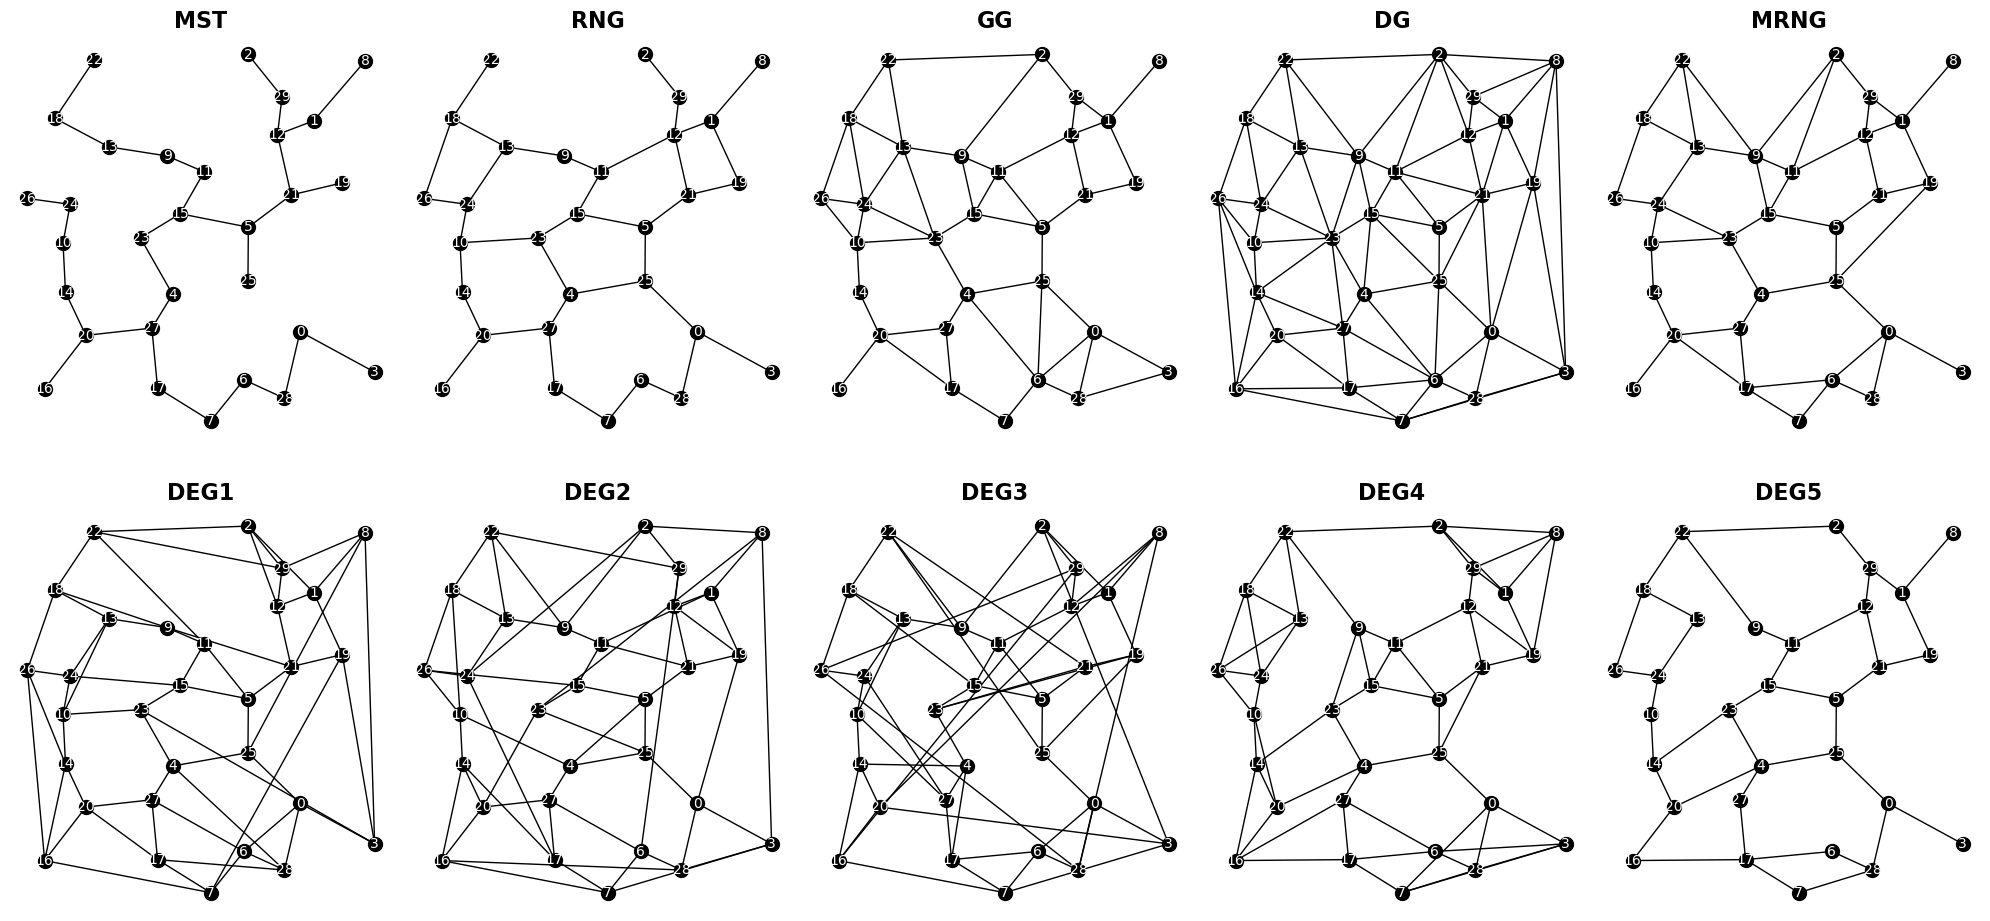

In [10]:
import matplotlib.pyplot as plt
from enum import Enum

class GraphType(Enum):
    KNN = ("kNN Graph", knn_edges)
    MST = ("MST", mst_edges)
    MRNG = ("MRNG", mrng_edges)
    RNG = ("RNG", rng_edges)
    GG = ("GG", gg_edges)
    DG = ("DG", dg_edges)
    DEG1 = ("DEG1", deg1_edges)
    DEG2 = ("DEG2", deg2_edges)
    DEG3 = ("DEG3", deg3_edges)
    DEG4 = ("DEG4", deg4_edges)
    DEG5 = ("DEG5", deg5_edges)

# select only desired graphs
selection = [GraphType.MST, GraphType.RNG, GraphType.GG, GraphType.DG, GraphType.MRNG, GraphType.DEG1, GraphType.DEG2, GraphType.DEG3, GraphType.DEG4, GraphType.DEG5]

# 2×4 grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()  # correct flattening

for ax, g in zip(axes, selection):
    title, edges = g.value
    edges.plot(ax=ax, color='black', linewidth=1)
    mst_vertices.plot(ax=ax, color='black', markersize=100)

    # add index labels
    for idx, point in mst_vertices.iterrows():
        x, y = point.geometry.x, point.geometry.y
        ax.text(x, y, str(idx), fontsize=10, color='white', ha='center', va='center')

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_aspect('equal')
    ax.axis('off')

# hide unused subplot if fewer than 8
for ax in axes[len(selection):]:
    ax.axis('off')

plt.tight_layout()
plt.savefig("plot.svg", format="svg", bbox_inches='tight')
plt.show()

# Edge Overlap

In [18]:
def print_edge_overlap(name, gdf_a, gdf_b):
    """
    Compare undirected edge sets of two GeoDataFrames and print formatted results.
    Prints:
      <name>: overlap_a/total_a (ratio_a_in_b)   overlap_b/total_b (ratio_b_in_a)  avg=<avg_dist_b>
    Returns tuple of all computed values.
    """
    a = gdf_a.copy()
    b = gdf_b.copy()

    # enforce undirected order
    a[['u', 'v']] = np.sort(a[['source', 'target']].values, axis=1)
    b[['u', 'v']] = np.sort(b[['source', 'target']].values, axis=1)

    merged = a.merge(b, on=['u', 'v'])
    overlap = len(merged)
    total_a = len(a)
    total_b = len(b)

    ratio_a_in_b = overlap / total_a if total_a else 0
    ratio_b_in_a = overlap / total_b if total_b else 0
    avg_dist_b = b["weight"].mean() if total_b else 0.0

    # print formatted line
    print("{:<8} {:>3}/{:>3} ({:7.2%})   {:>3}/{:>3} ({:7.2%})  avg={:7.3f}".format(
        name, overlap, total_a, ratio_a_in_b, overlap, total_b, ratio_b_in_a, avg_dist_b))

print_edge_overlap("KNN", mrng_edges, knn_edges)
print_edge_overlap("MST", mrng_edges, mst_edges)
print_edge_overlap("RNG", mrng_edges, rng_edges)
print_edge_overlap("DG",  mrng_edges, dg_edges)
print_edge_overlap("GG",  mrng_edges, gg_edges)
print_edge_overlap("DEG1", mrng_edges, deg1_edges)
print_edge_overlap("DEG2", mrng_edges, deg2_edges)
print_edge_overlap("DEG3", mrng_edges, deg3_edges)
print_edge_overlap("DEG4", mrng_edges, deg4_edges)
print_edge_overlap("DEG5", mrng_edges, deg5_edges)

KNN       45/ 47 ( 95.74%)    45/ 91 ( 49.45%)  avg= 22.696
MST       29/ 47 ( 61.70%)    29/ 29 (100.00%)  avg= 14.912
RNG       36/ 47 ( 76.60%)    36/ 36 (100.00%)  avg= 15.959
DG        46/ 47 ( 97.87%)    46/ 79 ( 58.23%)  avg= 23.182
GG        43/ 47 ( 91.49%)    43/ 51 ( 84.31%)  avg= 18.221
DEG1      37/ 47 ( 78.72%)    37/ 60 ( 61.67%)  avg= 25.738
DEG2      35/ 47 ( 74.47%)    35/ 60 ( 58.33%)  avg= 27.146
DEG3      37/ 47 ( 78.72%)    37/ 60 ( 61.67%)  avg= 31.585
DEG4      36/ 47 ( 76.60%)    36/ 60 ( 60.00%)  avg= 21.055
DEG5      34/ 47 ( 72.34%)    34/ 39 ( 87.18%)  avg= 18.056


# Search Performance

In [19]:
def exact_knn(coords, k=5):
    """
    Compute exact k-nearest neighbors using brute force distance matrix.
    coords: Nx2 numpy array
    returns: (indices, distances)
    """
    n = len(coords)
    distances = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2)
    np.fill_diagonal(distances, np.inf)  # ignore self-distance
    indices = np.argsort(distances, axis=1)[:, :k]
    dist_sorted = np.take_along_axis(distances, indices, axis=1)
    return indices, dist_sorted
indices_exact, dist_exact = exact_knn(coords, k=4)

# search query
graphs = {
    "DEG1": deg1_graph_ro,
    "DEG2": deg2_graph_ro,
    "DEG3": deg3_graph_ro,
    "DEG4": deg4_graph_ro,
    "DEG5": deg5_graph_ro
}

for name, g in graphs.items():
    indices_approx, distances_approx = g.search(coords, eps=0.0, k=5)
    recall = np.mean([
        len(set(indices_approx[i,1:]).intersection(indices_exact[i])) / len(indices_exact[i])
        for i in range(len(indices_exact))
    ])
    print(f"{name}: Recall = {recall:.3f}")

DEG1: Recall = 1.000
DEG2: Recall = 0.983
DEG3: Recall = 0.967
DEG4: Recall = 0.975
DEG5: Recall = 0.975
